# Tabular Playground Series - Jul 2021

In [ ]:
!pip3 install optuna
!pip3 install xgboost
!pip3 install lightgbm
!pip3 install catboost

     |████████████████████████████████| 301 kB 4.0 MB/s 
     |████████████████████████████████| 164 kB 7.3 MB/s 
     |████████████████████████████████| 80 kB 5.0 MB/s 
     |████████████████████████████████| 75 kB 2.9 MB/s 
     |████████████████████████████████| 111 kB 7.3 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 141 kB 7.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=66e0e50072c4ba9570ea12f46eb95001df6a505b12ab04d0fa560e9fed268a60
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 69.2 MB 4.7 kB/s 


In [ ]:
# Required modules

import shutil
import pickle
import optuna
import numpy as np
import pandas as pd

from google.colab import drive

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [ ]:
# Config

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

In [ ]:
# Mounting the drive

drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
# Moving the data into workspace

shutil.copy('/content/mydrive/MyDrive/myKaggle/Tabular Playground Series/tabular-playground-series-jul-2021.zip', './')

'./tabular-playground-series-jul-2021.zip'

In [ ]:
# Extracting the data

with ZipFile('/content/tabular-playground-series-jul-2021.zip', 'r') as zf:
    zf.extractall('./')

In [ ]:
# Load the train data

train = pd.read_csv('train.csv', parse_dates=['date_time'])
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [ ]:
# Inspecting the data

train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_time               7111 non-null   datetime64[ns]
 1   deg_C                   7111 non-null   float64       
 2   relative_humidity       7111 non-null   float64       
 3   absolute_humidity       7111 non-null   float64       
 4   sensor_1                7111 non-null   float64       
 5   sensor_2                7111 non-null   float64       
 6   sensor_3                7111 non-null   float64       
 7   sensor_4                7111 non-null   float64       
 8   sensor_5                7111 non-null   float64       
 9   target_carbon_monoxide  7111 non-null   float64       
 10  target_benzene          7111 non-null   float64       
 11  target_nitrogen_oxides  7111 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
count,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000
mean,20.878034,47.561004,1.110309,1091.572100,938.064970,883.903305,1513.238349,998.335565,2.086219,10.237083,204.066784
std,7.937917,17.398731,0.398950,218.537554,281.978988,310.456355,350.180310,381.537695,1.447109,7.694426,193.927723
min,1.300000,8.900000,0.198800,620.300000,364.000000,310.600000,552.900000,242.700000,0.100000,0.100000,1.900000
25%,14.900000,33.700000,0.855900,930.250000,734.900000,681.050000,1320.350000,722.850000,1.000000,4.500000,76.450000
50%,20.700000,47.300000,1.083500,1060.500000,914.200000,827.800000,1513.100000,928.700000,1.700000,8.500000,141.000000
75%,25.800000,60.800000,1.404150,1215.800000,1124.100000,1008.850000,1720.400000,1224.700000,2.800000,14.200000,260.000000
max,46.100000,90.800000,2.231000,2088.300000,2302.600000,2567.400000,2913.800000,2594.600000,12.500000,63.700000,1472.300000


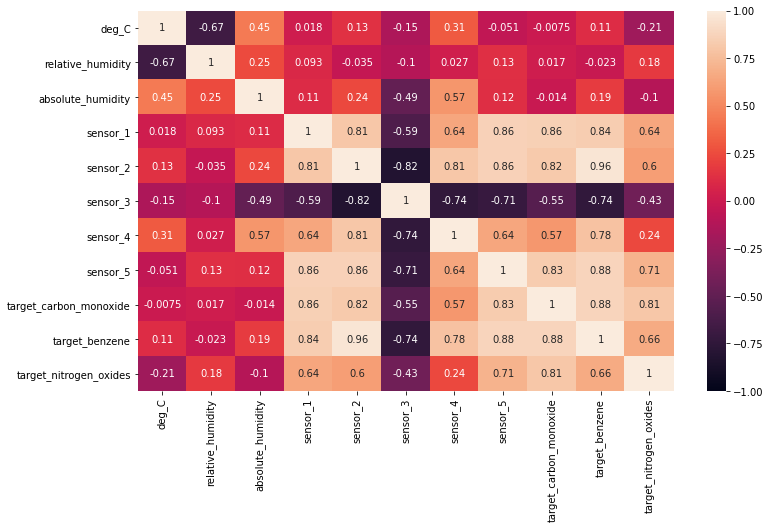

In [ ]:
# Correlation matrix

sns.heatmap(train.corr(), annot=True, vmin=-1, vmax=1)

In [ ]:
# Separating out features and labels

X = train.drop(['date_time', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'], axis=1)
y = train[['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]

In [ ]:
# Train and Test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=42)

In [ ]:
# Optuna Custom classes

class Optimize(BaseEstimator, TransformerMixin):
    def __init__(self, objective, n_trials=100, maximize=True) -> None:
        self.objective = objective
        self.direction = maximize
        self.n_trials = n_trials

    def __str__(self) -> str:
        return f"Optimize(objective={self.objective}, maximize={self.direction})"

    def fit_transform(self, X_train, y_train):
        self.fit(self.X_train, self.y_train)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

        if self.direction:
            self.study = optuna.create_study(direction='maximize')
        else:
            self.study = optuna.create_study(direction='minimize')
        self.study.optimize(self.objective, n_trials=self.n_trials)

        self.best_trail = self.study.best_trial

    def predict(self, X, save_model=True):
        model = eval(self.best_trail.params['clf']+'()')
        model_params = {k: v for k, v in self.best_trail.params.items() if k != 'clf'}
        model.set_params(**model_params)
        model.fit(self.X_train, self.y_train)

        if save_model:
            fname = 'saved_model.pkl'
            pickle.dump(model, open(fname, 'wb'))

        return model.predict(X)

class Objective():
    def __init__(self, X_train, y_train, X_valid, y_valid) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid

    def __call__(self, trail):
        clf = trail.suggest_categorical('clf', ['KNeighborsRegressor', 'DecisionTreeRegressor', 'Lasso', 'LinearRegression', 'RandomForestRegressor', 'Ridge', 'KNeighborsRegressor'])

        if clf == 'DecisionTreeRegressor':
            criterion = trail.suggest_categorical('criterion', ['mse', 'mae'])
            max_depth = trail.suggest_int('max_depth', 4, 14, step=2)
            max_features = trail.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])

            model = DecisionTreeRegressor(criterion=criterion, max_depth=max_depth, max_features=max_features)
        elif clf == 'RandomForestRegressor':
            n_estimators = trail.suggest_int('n_estimators', 100, 2000, step=50)
            criterion = trail.suggest_categorical('criterion', ['mse', 'mae'])
            max_depth = trail.suggest_int('max_depth', 4, 14, step=2)
            max_features = trail.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])

            model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, max_features=max_features)
        elif clf == 'Lasso':
            alpha = trail.suggest_loguniform('alpha', 1e-10, 1)

            model = Lasso(alpha=alpha)
        elif clf == 'LinearRegression':
            model = LinearRegression()
        elif clf == 'KNeighborsRegressor':
            n_neighbors = trail.suggest_int('n_neighbors', 2, 30)
            weights = trail.suggest_categorical('weights', ['uniform', 'distance'])
            algorithm = trail.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
            leaf_size = trail.suggest_int('leaf_size', 10, 50, step=5)
            p = trail.suggest_int('p', 3, 30)

            model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, p=p)
        elif clf == 'Ridge':
            alpha = trail.suggest_loguniform('alpha', 1e-10, 1)

            model = Ridge(alpha=alpha)
        # elif clf == 'SVR':
        #     tol = trail.suggest_loguniform('tol', 1e-6, 1)
        #     C = trail.suggest_loguniform('C', 1e-10, 1e2)
        #     kernel = trail.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        #     gamma = trail.suggest_categorical('gamma', ['scale', 'auto'])
        #     degree = trail.suggest_int('degree', 3, 15)

        #     model = SVR(kernel=kernel, gamma=gamma, degree=degree, tol=tol, C=C)
        # elif clf == 'XGBRegressor':
            # n_estimators = trail.suggest_int('n_estimators', 100, 2000, step=50)
            # learning_rate = trail.suggest_loguniform('learning_rate', 1e-10, 1)
            # max_depth = trail.suggest_int('max_depth', 4, 14, step=2)
            # reg_alpha = trail.suggest_loguniform('reg_alpha', 1e-10, 1)
# 
            # model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=reg_alpha)
        # elif clf == 'LGBMRegressor':
        #     boosting_type = trail.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss', 'rf'])
        #     num_leaves = trail.suggest_int('num_leaves', 10, 60)
        #     n_estimators = trail.suggest_int('n_estimators', 100, 2000, step=50)
        #     learning_rate = trail.suggest_loguniform('learning_rate', 1e-10, 1)
        #     max_depth = trail.suggest_int('max_depth', 4, 14, step=2)
        #     reg_alpha = trail.suggest_loguniform('reg_alpha', 1e-10, 1)

        #     model = LGBMRegressor(boosting_type=boosting_type, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=reg_alpha)
        # elif clf == 'CatBoostRegressor':
        #     iterations = trail.suggest_int('iterations', 100, 200, step=5)
        #     loss_function = trail.suggest_categorical('loss_function', ['RMSE', 'MAE', 'MAPE', 'Poisson'])
        #     learning_rate = trail.suggest_loguniform('learning_rate', 1e-10, 1)
        #     depth = trail.suggest_int('depth', 4, 14, step=2)

        #     model = CatBoostRegressor(loss_function=loss_function, iterations=iterations, depth=depth, learning_rate=learning_rate)

        model.fit(self.X_train, self.y_train)
        valid_pred = model.predict(self.X_valid)

        return np.sqrt(mean_squared_error(self.y_valid, valid_pred))

## ML Part

In [ ]:
# Fitting the model

obj = Objective(X_train, y_train, X_valid, y_valid)
pipe = Pipeline([
    ('optim', Optimize(obj, maximize=False)),
])

pipe.fit(X_train, y_train)

[I 2021-07-21 17:11:22,490] A new study created in memory with name: no-name-b0819dc3-56a7-47ae-9ff4-2212c085726d
[I 2021-07-21 17:11:22,501] Trial 0 finished with value: 68.33586531112435 and parameters: {'clf': 'LinearRegression'}. Best is trial 0 with value: 68.33586531112435.
[I 2021-07-21 17:11:23,317] Trial 1 finished with value: 56.89423130061421 and parameters: {'clf': 'KNeighborsRegressor', 'n_neighbors': 29, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 40, 'p': 11}. Best is trial 1 with value: 56.89423130061421.
[I 2021-07-21 17:11:26,387] Trial 2 finished with value: 59.8855034732263 and parameters: {'clf': 'DecisionTreeRegressor', 'criterion': 'mae', 'max_depth': 8, 'max_features': 'auto'}. Best is trial 1 with value: 56.89423130061421.
[I 2021-07-21 17:11:33,503] Trial 3 finished with value: 56.101056775242206 and parameters: {'clf': 'KNeighborsRegressor', 'n_neighbors': 24, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 15, 'p': 15}. Best is trial 3

Pipeline(memory=None,
         steps=[('optim',
                 Optimize(maximize=None, n_trials=100,
                          objective=<__main__.Objective object at 0x7f50969c84d0>))],
         verbose=False)

In [ ]:
# Load test data

test = pd.read_csv('test.csv', parse_dates=['date_time'])
test.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [ ]:
# Predictioin

test_pred = pipe.predict(test.drop(['date_time'], axis=1))
test_pred

array([[  1.56375631,   5.67046419, 240.48023089],
       [  2.53331401,   9.80644293, 379.66262219],
       [  2.24543857,   9.3342649 , 366.53321061],
       ...,
       [  2.83952302,  13.84692348, 361.67787327],
       [  2.06503529,   9.36237622, 252.49782095],
       [  2.31797704,  10.76395369, 283.25768048]])

In [ ]:
# Output

submission = pd.DataFrame(test_pred)
submission['date_time'] = test['date_time'].values
submission.columns = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides', 'date_time']
submission.to_csv('output.csv', index=False)